In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from tqdm import tqdm_notebook
from IPython.display import display

import os

In [2]:
data_dir = 'datasets/clean/'

In [15]:
behav = pd.read_csv(data_dir+'steam_behaviour_info.csv')
print(behav.shape)
behav.head()

(70489, 3)


,user_id,hours,title
0,151603712,273.0,The Elder Scrolls V: Skyrim
1,151603712,87.0,Fallout 4
2,151603712,14.9,Storm
3,151603712,12.1,Fallout: New Vegas
4,151603712,8.9,Left 4 Dead 2


## Analysis of stats per-player 

Both distributions follow a _sharp_ (exponential) decaying curve with outliers. The outliers have been clipped at the 99<sup>th</sup> percentile. Even then both variables are highly skewed so a logarithmic scale was introduced. 

Even though both distributions have roughly the same shape, the `num_hours_played` variable has a much wider spread represented by the `peak-to-peak` value or range.

In [12]:
def plot_hist(x_data, xlabel, title):
    print(f'Range: {x_data.ptp():.2f}')
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16,5), dpi=80)

    sns.distplot(x_data, kde=False, hist_kws={'log':False}, ax=ax1);
    ax1.set_xlabel(xlabel)
    ax1.set_title(title);

    sns.distplot(x_data, kde=False, hist_kws={'log':True}, ax=ax2);
    ax2.set_xlabel(xlabel)
    ax2.set_title(title+' (log)');

Range: 84.00


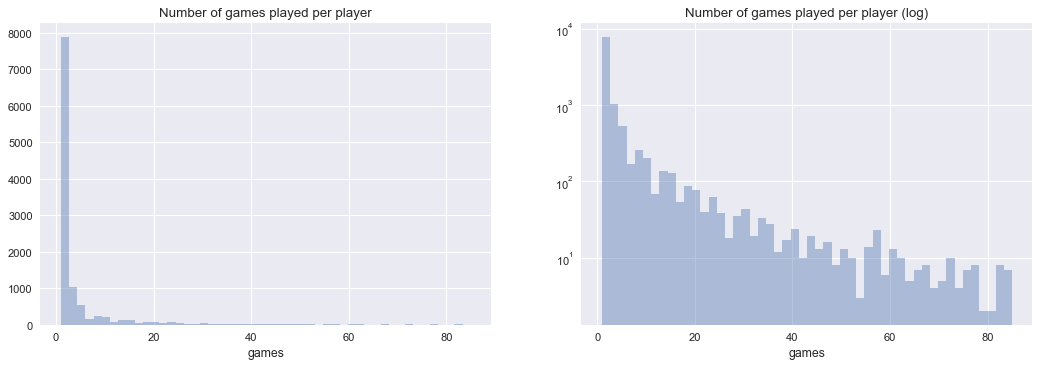

In [16]:
num_games_played = behav.groupby('user_id').count()['title']
plot_hist(num_games_played[num_games_played < num_games_played.quantile(0.99)], 
          'games', 'Number of games played per player')

Range: 3960.50


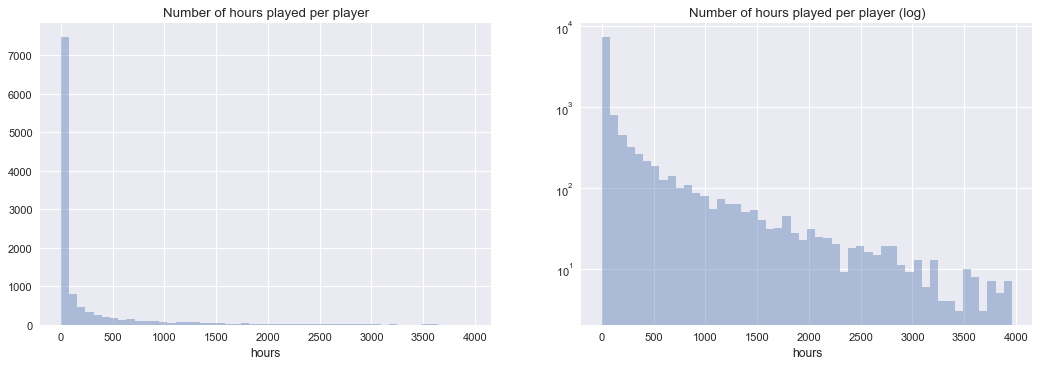

In [17]:
num_hours_played = behav.groupby('user_id').sum()['hours']
plot_hist(num_hours_played[num_hours_played < num_hours_played.quantile(0.99)], 
         'hours', 'Number of hours played per player')

## Building the Vocabulary

The vector `all_behav_games` is the 'vocabulary' we will use to construct the 'bag-of-words'-like representation.

In [26]:
all_behav_games = behav['title'].unique()
game_vocab_size = len(all_behav_games)

all_behav_users = behav['user_id'].unique()
user_vocab_size = len(all_behav_users)

game_vocab_size, user_vocab_size

(3256, 11350)

In [21]:
def find_vocab_index(name):
    found = np.where(all_behav_games==name)
    return found[0][0]

def find_user_index(user_id):
    found = np.where(all_behav_users==user_id)
    return found[0][0]

In [25]:
behav['game_index'] = behav['title'].apply(find_vocab_index)
behav['user_index'] = behav['user_id'].apply(find_user_index)
behav.head()

,user_id,hours,title,game_index,user_index
0,151603712,273.0,The Elder Scrolls V: Skyrim,0,0
1,151603712,87.0,Fallout 4,1,0
2,151603712,14.9,Storm,2,0
3,151603712,12.1,Fallout: New Vegas,3,0
4,151603712,8.9,Left 4 Dead 2,4,0


## Bag-of-Words Representation 

Both these feature matrices are arranged in 'User-first' order this means that each record/feature/row corresponds to a single user. Transpose these to obtain 'Game-first' features

In [37]:
onehot_by_user = np.zeros((user_vocab_size, game_vocab_size), dtype='uint8')
onehot_by_user[behav['user_index'],behav['game_index']] = 1

time_by_user = np.zeros((user_vocab_size, game_vocab_size), dtype='uint8')
time_by_user[behav['user_index'],behav['game_index']] = behav['hours']

print('Feature Matrix:', onehot_by_user.shape)

Feature Matrix: (11350, 3256)


## Genre Information

The `game_info` dataframe contains genre information about each game in form of several columns comprising of a one-hot representation. We now need a categorical (string) representation of the genre which we can use to better visualize the data.

A predefined list of genres is used to categorize each game, if a game does not fall in any of these then it is placed in 'Other' genre. 

In [39]:
game_info = pd.read_csv(data_dir+'steam_game_info.csv')
print(game_info.shape)
game_info.head()

(13357, 41)


,ResponseName,ReleaseDate,RequiredAge,Metacritic,MovieCount,PackageCount,RecommendationCount,SteamSpyOwners,SteamSpyOwnersVariance,SteamSpyPlayersEstimate,...,GenreIsRPG,GenreIsSimulation,GenreIsEarlyAccess,GenreIsFreeToPlay,GenreIsSports,GenreIsRacing,GenreIsMassivelyMultiplayer,PriceCurrency,PriceInitial,PriceFinal
0,Counter-Strike,Nov 1 2000,0,88,0,1,68991,13033334,92789,9140731,...,False,False,False,False,False,False,False,USD,9.99,9.99
1,Team Fortress Classic,Apr 1 1999,0,0,0,1,2439,5399140,60368,753627,...,False,False,False,False,False,False,False,USD,4.99,4.99
2,Day of Defeat,May 1 2003,0,79,0,1,2319,7621102,71499,1709740,...,False,False,False,False,False,False,False,USD,4.99,4.99
3,Deathmatch Classic,Jun 1 2001,0,0,0,1,888,7498965,70936,789676,...,False,False,False,False,False,False,False,USD,4.99,4.99
4,Half-Life: Opposing Force,Nov 1 1999,0,0,0,1,2934,5399499,60370,705741,...,False,False,False,False,False,False,False,USD,4.99,4.99


In [38]:
genre_cols = ['GenreIsAction','GenreIsAdventure','GenreIsCasual','GenreIsStrategy','GenreIsRPG','GenreIsSimulation','GenreIsSports','GenreIsRacing','GenreIsMassivelyMultiplayer']
genre_names = [g.lstrip('GenreIs') for g in genre_cols]

In [40]:
np.where(game_info[genre_cols].sum(axis=1) != 1)
game_info[genre_cols].sum(axis=1).describe()

count    13357.000000
mean         1.627162
std          1.046081
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          9.000000
dtype: float64

The problem here is that the genres are not mutually exclusive for a given game. Each game can have more than one (upto 9, which is all of them) genres.

This means we can not obtain a single string representation of the genre for a single game. 

In [41]:
def add_columns_after_join(left, right, new_cols, on=None):
    left_on, right_on = on
    old_cols = left.columns.tolist().copy()
    old_cols.extend(new_cols)
    return left.merge(right.drop_duplicates(subset=[right_on]), how='left', 
                      left_on=left_on, right_on=right_on)[old_cols]

def dummy_to_categorical(df, dummy_cols, new_col, keep_dummies=False):
    x = df[dummy_cols].stack()
    df[new_col] = pd.Series(pd.Categorical(x[x!=0].index.get_level_values(1)))
    
    if keep_dummies:
        return df
    return df.drop(dummy_cols, axis=1)

def dummy_to_list(df, dummy_cols, new_col, keep_dummies=False):
    new_series = []
    dummy_cols_arr = np.array(dummy_cols)
    for _,row in df[dummy_cols].iterrows():
        new_series.append(dummy_cols_arr[row.tolist()])
    df[new_col] = pd.Series(new_series)
    
    if keep_dummies:
        return df
    return df.drop(dummy_cols, axis=1)

In [42]:
behav_with_genre = add_columns_after_join(behav, game_info, new_cols=genre_cols, on=['title','ResponseName'])
behav_with_genre = dummy_to_list(behav_with_genre, genre_cols, 'genre')
behav_with_genre['genre'] = behav_with_genre['genre'].apply(lambda l: [g.lstrip('GenreIs') for g in l])

print(behav_with_genre.shape)
behav_with_genre.head()

(70489, 6)


,user_id,hours,title,game_index,user_index,genre
0,151603712,273.0,The Elder Scrolls V: Skyrim,0,0,[RPG]
1,151603712,87.0,Fallout 4,1,0,[RPG]
2,151603712,14.9,Storm,2,0,[Simulation]
3,151603712,12.1,Fallout: New Vegas,3,0,"[Action, RPG]"
4,151603712,8.9,Left 4 Dead 2,4,0,[Action]


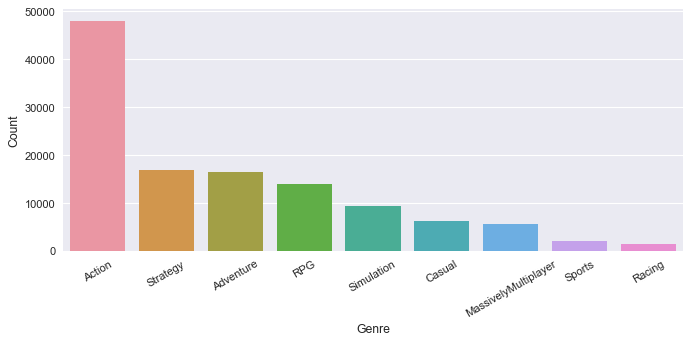

In [44]:
def list_series_isin(s, target_l):
    return s.apply(lambda l: np.any([i in target_l for i in l]))

genre_dfs = {}
genre_counts = {}
for genre_name in tqdm_notebook(genre_names):
    genre_dfs[genre_name] = behav_with_genre[list_series_isin(behav_with_genre['genre'], [genre_name])]
    genre_counts[genre_name] = len(genre_dfs[genre_name])

genre_counts = pd.DataFrame.from_dict(genre_counts, orient='index', columns=['Count'])
genre_counts['Genre'] = genre_counts.index
genre_counts = genre_counts.reset_index(drop=True)

fig, ax = plt.subplots(figsize=(10,4), dpi=80)
desc_order = genre_counts.sort_values('Count', ascending=False)['Genre']
g = sns.barplot(data=genre_counts, x='Genre', y='Count', order=desc_order, ax=ax);
g.set_xticklabels(g.get_xticklabels(), rotation=30);

## Visualizing play-time vectors